In [6]:
import os
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')
df['userId'] = df['userId'].astype('category').cat.codes
df['movieId'] = df['movieId'].astype('category').cat.codes + df['userId'].nunique()

# Create a graph
edge_index = torch.tensor(df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous()
x = torch.ones(df['userId'].nunique() + df['movieId'].nunique(), 1)

# Split the data into training and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create graph data for training and test sets
train_data = Data(x=x, edge_index=torch.tensor(train_df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous(), y=torch.tensor(train_df['rating'].values, dtype=torch.float))
test_data = Data(x=x, edge_index=torch.tensor(test_df[['userId', 'movieId']].values, dtype=torch.long).t().contiguous(), y=torch.tensor(test_df['rating'].values, dtype=torch.float))


In [7]:
# Define the GNN model
class GNNRecommendation(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GNNRecommendation, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.out(x)
        return x.view(-1)

In [8]:
# Additional evaluation metrics

# RMSE function
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())


def mae(predictions, targets):
    return torch.abs(predictions - targets).mean()

def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()

# Evaluation function
def evaluate(data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)[data.edge_index[0]]
        loss_mse = mse(predictions, data.y)
        rmse_value = rmse(predictions, data.y).item()
        mae_value = mae(predictions, data.y).item()
    return loss_mse.item(), rmse_value, mae_value

In [9]:
# Training function
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.edge_index[0]], data.y)
    loss.backward()
    optimizer.step()
    return loss.item()


# Initialize the model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNRecommendation(1, 16).to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [10]:
# Training loop
epochs = 20
train_losses = []
test_losses = []
train_rmses = []
test_rmses = []
train_maes = []
test_maes = []
train_mses = []  # Store MSE for training data
test_mses = []

for epoch in range(epochs):
    train_loss = train(train_data)
    test_loss, test_rmse, test_mae = evaluate(test_data)
    train_rmse_value = train(train_data)
    train_mae_value = mae(model(train_data)[train_data.edge_index[0]], train_data.y).item()
    train_mse_value = mse(model(train_data)[train_data.edge_index[0]], train_data.y).item()  # Compute MSE for training data

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_rmses.append(train_rmse_value)
    test_rmses.append(test_rmse)
    train_maes.append(train_mae_value)
    test_maes.append(test_mae)
    train_mses.append(train_mse_value)  # Append MSE for training data
    test_mses.append(test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train RMSE: {train_rmse_value:.4f}, Test RMSE: {test_rmse:.4f}, Train MAE: {train_mae_value:.4f}, Test MAE: {test_mae:.4f}, Train MSE: {train_mse_value:.4f}, Test MSE: {test_loss:.4f}")

Epoch 1/20, Train Loss: 13.0692, Test Loss: 12.7513, Train RMSE: 12.7601, Test RMSE: 3.5709, Train MAE: 3.3558, Test MAE: 3.4099, Train MSE: 12.4024, Test MSE: 12.7513
Epoch 2/20, Train Loss: 12.3857, Test Loss: 12.1105, Train RMSE: 12.0665, Test RMSE: 3.4800, Train MAE: 3.2573, Test MAE: 3.3146, Train MSE: 11.7607, Test MSE: 12.1105
Epoch 3/20, Train Loss: 11.7167, Test Loss: 11.4090, Train RMSE: 11.4009, Test RMSE: 3.3777, Train MAE: 3.1340, Test MAE: 3.2071, Train MSE: 10.9869, Test MSE: 11.4090
Epoch 4/20, Train Loss: 10.9332, Test Loss: 10.5956, Train RMSE: 10.6240, Test RMSE: 3.2551, Train MAE: 2.9973, Test MAE: 3.0776, Train MSE: 10.0776, Test MSE: 10.5956
Epoch 5/20, Train Loss: 10.0914, Test Loss: 9.6302, Train RMSE: 9.5983, Test RMSE: 3.1033, Train MAE: 2.8102, Test MAE: 2.9195, Train MSE: 8.9342, Test MSE: 9.6302
Epoch 6/20, Train Loss: 9.2137, Test Loss: 8.4719, Train RMSE: 8.4968, Test RMSE: 2.9107, Train MAE: 2.5839, Test MAE: 2.7182, Train MSE: 8.1132, Test MSE: 8.4719
E

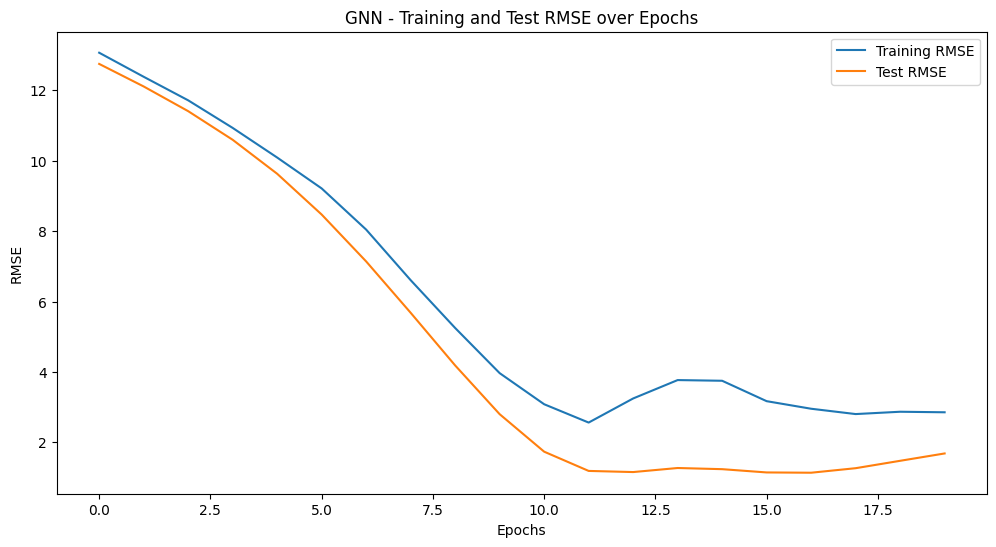

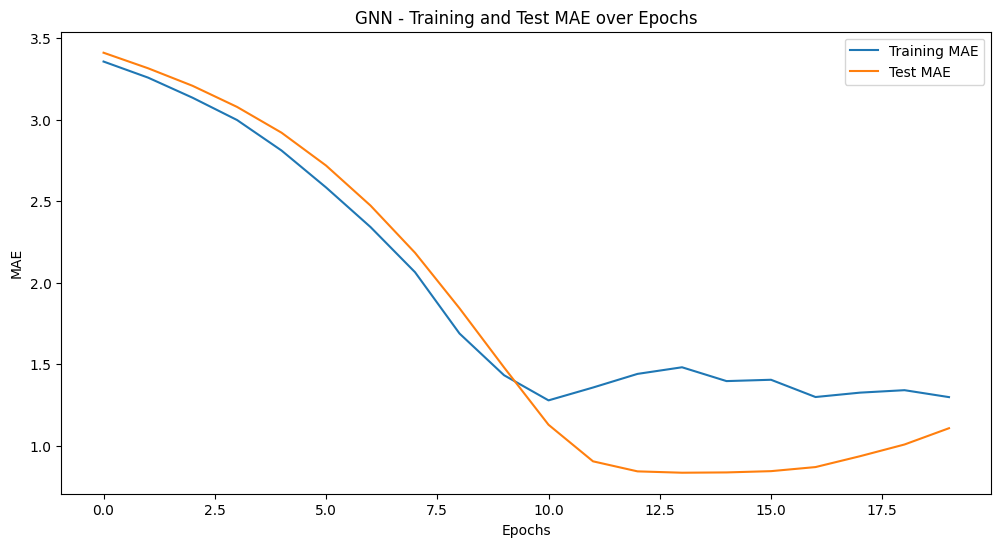

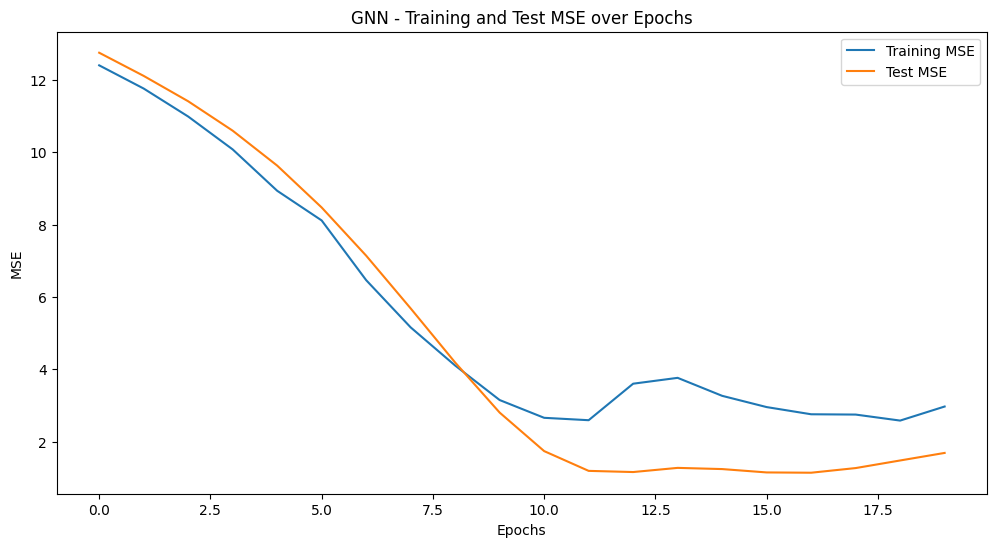

In [16]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
output_folder = "../../metrics/overleaf"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define model name
model_name = "GNN"

# Visualization

# RMSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training RMSE')
plt.plot(test_losses, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'{model_name} - Training and Test RMSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_rmse_plot.png'))  # Save the figure
plt.show()

# MAE plot
plt.figure(figsize=(12, 6))
plt.plot(train_maes, label='Training MAE')
plt.plot(test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title(f'{model_name} - Training and Test MAE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mae_plot.png'))  # Save the figure
plt.show()

# MSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_mses, label='Training MSE')
plt.plot(test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title(f'{model_name} - Training and Test MSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mse_plot.png'))  # Save the figure
plt.show()
